## 36118: Applied Natural Language Processing (ANLP)

### AT2 Part B

### Group 27: HD Innovators

## Genre Classification

Contents:

1. Load and explore the data
2. Data preparation
3. Split data
4. Genre Classification Models

   4.1 Multinomial Naive Bayes
   
   4.2 CatBoost Classifier
5. Model Evaluation

In [52]:
# Import packages
# Python packages
import pandas as pd
import numpy as np

# NLTK packages
import nltk
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

# Vectorisation package 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Split data package
from sklearn.model_selection import train_test_split

# Naive Bayes model
from sklearn.naive_bayes import MultinomialNB

# CatBoost Classifier model
from catboost import Pool, CatBoostClassifier

# Evaluation package
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Hyperparameters Tuning package
from sklearn.pipeline import Pipeline
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Data visualisation package
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Load and explore the data

In [53]:
# Import data.
df_lyrics = pd.read_csv('/Users/monalipatil/ANLP/AT2/data/data_filtered.csv')

In [54]:
# Check summary information.
df_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11978 entries, 0 to 11977
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    11978 non-null  int64  
 1   artist_name   11978 non-null  object 
 2   track_name    11978 non-null  object 
 3   release_date  11978 non-null  int64  
 4   genre         11978 non-null  object 
 5   lyrics        11978 non-null  object 
 6   len           11978 non-null  int64  
 7   valence       11978 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 748.8+ KB


In [55]:
# Describe summary statistics.
df_lyrics.describe()

,Unnamed: 0,release_date,len,valence
count,11978.000000,11978.000000,11978.000000,11978.000000
mean,16153.030473,1994.581232,106.949324,0.568380
std,7169.281975,17.132621,37.214055,0.245457
min,5.000000,1950.000000,56.000000,0.000000
25%,10682.500000,1982.000000,76.000000,0.375515
50%,17074.000000,1996.000000,98.000000,0.586768
75%,22211.750000,2010.000000,130.000000,0.767879
max,27467.000000,2019.000000,199.000000,1.000000


In [56]:
# Describe summary statistics for all datatype.
df_lyrics.describe(include='all')

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,valence
count,11978.000000,11978,11978,11978.000000,11978,11978,11978.000000,11978.000000
unique,NaN,3622,10981,NaN,6,11978,NaN,NaN
top,NaN,ella fitzgerald,fever,NaN,blues,cold chamber smoke kush gettin higher plane sw...,NaN,NaN
freq,NaN,49,11,NaN,2000,1,NaN,NaN
mean,16153.030473,NaN,NaN,1994.581232,NaN,NaN,106.949324,0.568380
std,7169.281975,NaN,NaN,17.132621,NaN,NaN,37.214055,0.245457
min,5.000000,NaN,NaN,1950.000000,NaN,NaN,56.000000,0.000000
25%,10682.500000,NaN,NaN,1982.000000,NaN,NaN,76.000000,0.375515
50%,17074.000000,NaN,NaN,1996.000000,NaN,NaN,98.000000,0.586768
75%,22211.750000,NaN,NaN,2010.000000,NaN,NaN,130.000000,0.767879


In [57]:
# Check columns.
df_lyrics.columns

Index(['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre',
       'lyrics', 'len', 'valence'],
      dtype='object')

In [58]:
# Check if any missing values.
for column in df_lyrics.columns:
    print(column, df_lyrics[column].isnull().sum())

Unnamed: 0 0
artist_name 0
track_name 0
release_date 0
genre 0
lyrics 0
len 0
valence 0


In [59]:
# Check first few rows. 
df_lyrics.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,valence
0,13923,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791
1,14958,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930
2,15045,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561
3,15691,carl sims,it's just a party,2004,blues,girls knock ghetto ballin real thugs unngghhhh...,198,0.705276
4,16322,rufus thomas,sixty minute man,2011,blues,diddle devil yabba double walk feel body feel ...,198,0.651690


### 2. Data preparation

In [60]:
# Remove 'Unnamed: 0' column. 
df_lyrics.drop(['Unnamed: 0'], axis=1, inplace=True) 

Tokenise & Remove Punctuations

In [61]:
# Convert all data of lyrics to string type.
df_lyrics['lyrics'] = df_lyrics['lyrics'].apply(str)

# Convert all string of lyrics to lowercase.
df_lyrics['lyrics'] = df_lyrics['lyrics'].str.lower()

# Tokenize text from lyrics. 
df_lyrics['tokenized'] = df_lyrics['lyrics'].apply(word_tokenize)

# Remove punctuations.
punc_marks = list(string.punctuation)
df_lyrics['tokenized'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in punc_marks])
                                                                       
# Display smaple data. 
df_lyrics.sample(5)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized
7735,the cranberries,promises,1999,pop,better believe come better believe better hold...,103,0.258038,"[better, believe, come, better, believe, bette..."
2949,eddie money,calm before the storm,1986,country,whoa believe heaven knock hit listen tell stop...,89,0.335326,"[whoa, believe, heaven, knock, hit, listen, te..."
9120,alborosie,kingdom of zion,2008,reggae,wicked enter kingdom zion stand blaze fiyah ri...,97,0.738252,"[wicked, enter, kingdom, zion, stand, blaze, f..."
6875,fall out boy,thnks fr th mmrs,2007,pop,go bend break send wing prayer good time roll ...,137,0.562036,"[go, bend, break, send, wing, prayer, good, ti..."
2550,jelly roll,only,2017,country,miss finally take control drug finally take to...,105,0.474444,"[miss, finally, take, control, drug, finally, ..."


Remove Stopwords

In [62]:
# Use stopwords to remove stop words.
stopwords = nltk.corpus.stopwords.words('english')

# Add personalised list of stop words.
stopwords.extend(["'m", "'s", "'d", "hi", "im", "wa", "n't", "'get", "'ll", "'re", "'ve", "get", "still", "mmm", "ooh", "oooh", "yah", "yeh","mmm", "hmm"])

# Remove the stop words from the dataset. 
df_lyrics['cleaned_stopwords'] = df_lyrics['tokenized'].apply(lambda x: [word for word in x if word not in stopwords])

# Check first few rows. 
df_lyrics.head(3)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords
0,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p..."
1,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b..."
2,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,..."


Lemmatization

In [63]:
# Function to attain part of speech of words.
def determine_wordnet_speech(word_tag):
    if word_tag.startswith('J'):
        return wordnet.ADJ
    elif word_tag.startswith('V'):
        return wordnet.VERB
    elif word_tag.startswith('N'):
        return wordnet.NOUN
    elif word_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Add part of speech tags.
df_lyrics['pos_tags'] = df_lyrics['cleaned_stopwords'].apply(nltk.tag.pos_tag)

# Function to get part of speech in WordNet format.
df_lyrics['pos_tags'] = df_lyrics['pos_tags'].apply(lambda x: [(word, determine_wordnet_speech(pos_tag)) for (word, pos_tag) in x])

# Lemmatize words.
word_lemmatizer = WordNetLemmatizer()
df_lyrics['lyrics_lemmatized'] = df_lyrics['pos_tags'].apply(lambda x: [word_lemmatizer.lemmatize(word, tag) for word, tag in x])

# Convert list to string datatype. 
df_lyrics['lyrics_lemmatized'] = [' '.join(map(str,l)) for l in df_lyrics['lyrics_lemmatized']]

# Check few rows.
df_lyrics.head(3)

,artist_name,track_name,release_date,genre,lyrics,len,valence,tokenized,cleaned_stopwords,pos_tags,lyrics_lemmatized
0,santana,wham!,1978,blues,cold chamber smoke kush gettin higher plane sw...,198,0.857791,"[cold, chamber, smoke, kush, gettin, higher, p...","[cold, chamber, smoke, kush, gettin, higher, p...","[(cold, a), (chamber, n), (smoke, v), (kush, n...",cold chamber smoke kush gettin high plane swan...
1,marvin sease,show me what you got,1991,blues,public service announcement weezy baby best ra...,198,0.794930,"[public, service, announcement, weezy, baby, b...","[public, service, announcement, weezy, baby, b...","[(public, a), (service, n), (announcement, n),...",public service announcement weezy baby best ra...
2,the robert cray band,1040 blues,1993,blues,gotta rapper today forget fuck smokin brain ce...,198,0.613561,"[got, ta, rapper, today, forget, fuck, smokin,...","[got, ta, rapper, today, forget, fuck, smokin,...","[(got, v), (ta, a), (rapper, n), (today, n), (...",get ta rapper today forget fuck smokin brain c...


In [64]:
# Check counts per genre
df_lyrics['genre'].value_counts()

blues      2000
country    2000
jazz       2000
pop        2000
rock       2000
reggae     1978
Name: genre, dtype: int64

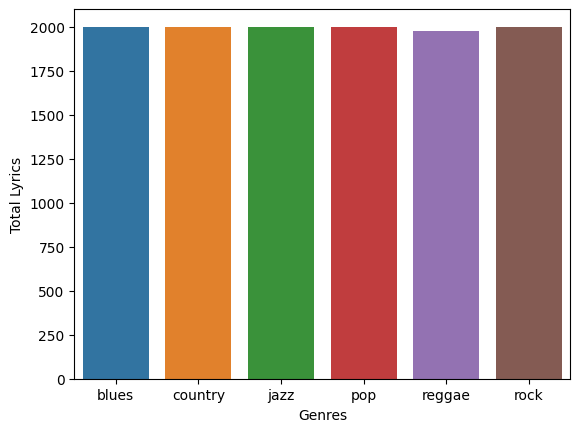

<Figure size 600x400 with 0 Axes>

In [65]:
sns.countplot(data=df_lyrics, x='genre')
plt.ylabel('Total Lyrics')
plt.xlabel('Genres')
plt.figure(figsize=(6,4))
plt.show()

In [66]:
# Extract unique genres
x = df_lyrics.genre.unique()

# Create dictionary to map each genre to a unique index and its corresponding genre name.
lyrics_genre_idx = {}
idx_to_lyrics = {}
j = 0
for i in x:
    lyrics_genre_idx[i] = j
    idx_to_lyrics[j] = i
    j += 1
lyrics_genre_idx

# Map genre labels to category IDs
genre_labels = df_lyrics.genre.map(lyrics_genre_idx)
df_lyrics['category_id'] = genre_labels

# Create a dataframe with genre and category ID pairs
df_category_id = df_lyrics[['genre', 'category_id']].drop_duplicates()


### 3. Split the data

In [99]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_lyrics['lyrics_lemmatized'], df_lyrics['genre'], test_size=0.2, random_state=42)

### 4.1 Genre Classification - Multinomial Naive Bayes Model

TF-IDF text representation

In [100]:
# Transform lyrics text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_train_features = vectorizer.fit_transform(X_train)
X_test_features = vectorizer.transform(X_test)

Modelling

In [101]:
# Train the model using Multinomial Naive Bayes algorithm
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_features, y_train)

MultinomialNB()

In [102]:
# Predict using training set
y_train_pred = nb_classifier.predict(X_train_features)

# Calculate performance of the model on the training set
print('Accuracy Training:', accuracy_score(y_train, y_train_pred))


Accuracy Training: 0.63055729492799


### 5. Model Evaluation

In [103]:
# Predict on the testing set
y_test_pred = nb_classifier.predict(X_test_features)

# Calculate performance of the model on the testing set
print('Accuracy Testing:', accuracy_score(y_test, y_test_pred))

Accuracy Testing: 0.38898163606010017


In [104]:
# Calculate the confusion matrix and classification report - Training
cm_training = confusion_matrix(y_train, y_train_pred)
cr_training = classification_report(y_train, y_train_pred)

# Print the classification report
print('Classification Report:', cr_training)


Classification Report:
               precision    recall  f1-score   support

       blues       0.81      0.43      0.56      1600
     country       0.51      0.85      0.64      1590
        jazz       0.84      0.51      0.64      1572
         pop       0.54      0.68      0.60      1609
      reggae       0.85      0.62      0.71      1587
        rock       0.57      0.69      0.63      1624

    accuracy                           0.63      9582
   macro avg       0.69      0.63      0.63      9582
weighted avg       0.69      0.63      0.63      9582



In [105]:
# Calculate the confusion matrix and classification report - Testing
cm_testing = confusion_matrix(y_test, y_test_pred)
cr_testing = classification_report(y_test, y_test_pred)

# Print the classification report
print('Classification Report:', cr_testing)



Classification Report:
               precision    recall  f1-score   support

       blues       0.39      0.13      0.19       400
     country       0.41      0.70      0.52       410
        jazz       0.42      0.20      0.27       428
         pop       0.33      0.45      0.38       391
      reggae       0.63      0.42      0.50       391
        rock       0.30      0.44      0.36       376

    accuracy                           0.39      2396
   macro avg       0.41      0.39      0.37      2396
weighted avg       0.41      0.39      0.37      2396



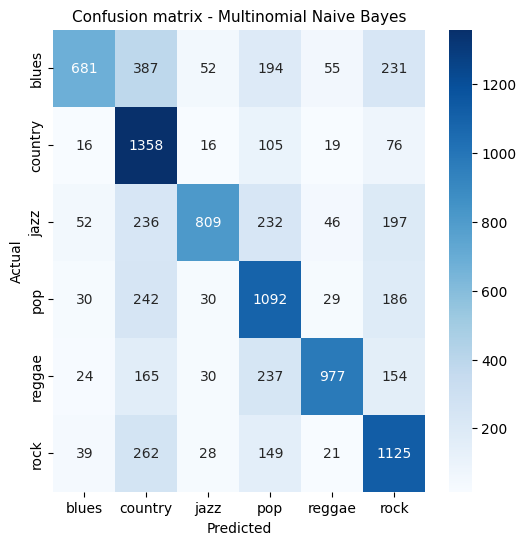

In [106]:
# Confusion matrix - Training
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm_training, annot=True, cmap='Blues', fmt='d', xticklabels=df_category_id.genre.values, yticklabels=df_category_id.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix - Multinomial Naive Bayes', size=11);

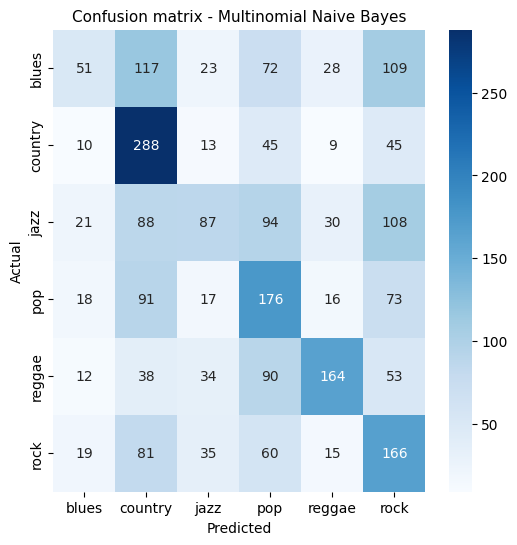

In [107]:
# Confusion matrix - Testing
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm_testing, annot=True, cmap='Blues', fmt='d', xticklabels=df_category_id.genre.values, yticklabels=df_category_id.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix - Multinomial Naive Bayes', size=11);

Tuning Hyperparameters

In [108]:
# Define the pipeline
pipeline = Pipeline([('tfidf', TfidfVectorizer()),  ('nb', MultinomialNB()),])

In [109]:
# Define the parameter grid for GridSearchCV
# The grid consist of Unigrams or bigrams and smoothing parameter
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],     
    'nb__alpha': [0.1, 0.5, 1.0],}

Grid search

In [110]:
# Perform grid search to find the best hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.1, 0.5, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]})

In [111]:
# Print the best hyperparameters and best score
print('Best Hyperparameters: ', grid_search.best_params_)
print('Best Score: ', grid_search.best_score_)

Best Hyperparameters:  {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best Score:  0.3939685900137545


In [112]:
# Evaluate the model performance on the testing set
accuracy = grid_search.score(X_test, y_test)
print('Accuracy on Testing Set: ', accuracy)

Accuracy on Testing Set:  0.4031719532554257


In [113]:
# Calculate the confusion matrix and classification report - Testing
y_test_pred = grid_search.predict(X_test)
cm_testing = confusion_matrix(y_test, y_test_pred)
cr_testing = classification_report(y_test, y_test_pred)

# Print the classification report
print('Classification Report:', cr_testing)


Classification Report:
               precision    recall  f1-score   support

       blues       0.33      0.20      0.24       400
     country       0.45      0.64      0.53       410
        jazz       0.43      0.24      0.30       428
         pop       0.38      0.43      0.41       391
      reggae       0.61      0.44      0.51       391
        rock       0.30      0.49      0.37       376

    accuracy                           0.40      2396
   macro avg       0.42      0.41      0.39      2396
weighted avg       0.42      0.40      0.39      2396



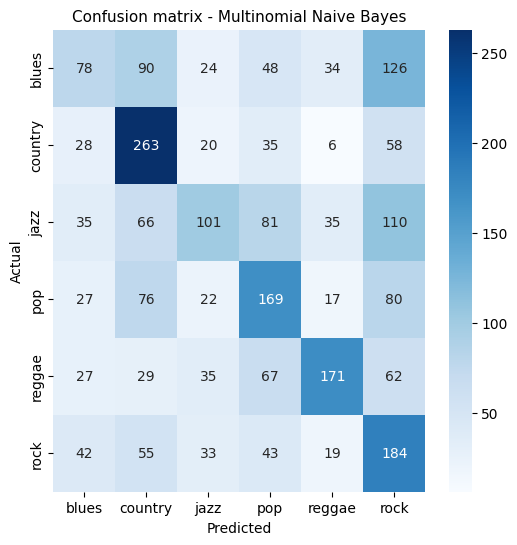

In [114]:
# Confusion matrix - Testing
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm_testing, annot=True, cmap='Blues', fmt='d', xticklabels=df_category_id.genre.values, yticklabels=df_category_id.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix - Multinomial Naive Bayes', size=11);

### 4.2 Genre Classification - CatBoost Classifier Model

Vectorisation text representation

In [81]:
# Transform lyrics text using CountVectorizer
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

Modelling

In [82]:
# Build and train a classifier
cat_features = None
train_dataset = Pool(data=X_train_vectorized, label=y_train, cat_features = cat_features)
cat_boot_model1 = CatBoostClassifier(iterations=100, learning_rate=1, depth=5, loss_function='MultiClass')
cat_boot_model1.fit(train_dataset)

0:	learn: 1.7559595	total: 116ms	remaining: 11.5s
1:	learn: 1.7324245	total: 246ms	remaining: 12.1s
2:	learn: 1.7235301	total: 375ms	remaining: 12.1s
3:	learn: 1.7106259	total: 519ms	remaining: 12.4s
4:	learn: 1.7025810	total: 670ms	remaining: 12.7s
5:	learn: 1.6936405	total: 835ms	remaining: 13.1s
6:	learn: 1.6853456	total: 1.01s	remaining: 13.4s
7:	learn: 1.6728257	total: 1.22s	remaining: 14s
8:	learn: 1.6631220	total: 1.38s	remaining: 13.9s
9:	learn: 1.6512058	total: 1.52s	remaining: 13.7s
10:	learn: 1.6329298	total: 1.66s	remaining: 13.4s
11:	learn: 1.6182771	total: 1.81s	remaining: 13.3s
12:	learn: 1.6015676	total: 1.93s	remaining: 12.9s
13:	learn: 1.5880222	total: 2.07s	remaining: 12.7s
14:	learn: 1.5771828	total: 2.2s	remaining: 12.5s
15:	learn: 1.5666399	total: 2.33s	remaining: 12.2s
16:	learn: 1.5564982	total: 2.46s	remaining: 12s
17:	learn: 1.5498673	total: 2.59s	remaining: 11.8s
18:	learn: 1.5444527	total: 2.72s	remaining: 11.6s
19:	learn: 1.5391083	total: 2.85s	remaining: 1

In [83]:
# Predict using training set 
y_train_pred = cat_boot_model1.predict(X_train_vectorized)

# Calculate performance of the model on the training set
print('Accuracy Training:', accuracy_score(y_train, y_train_pred))

Accuracy Training: 0.48925067835524944


### 5. Model Evaluation

In [85]:
# Predict using testing set
y_test_pred = cat_boot_model1.predict(X_test_vectorized)

# Calculate performance of the model on the testing set
print('Accuracy Testing:', accuracy_score(y_test, y_test_pred))

Accuracy Testing: 0.3555926544240401


Tuning Hyperparameters

In [86]:
# Build a classifier
catboost_model2 = CatBoostClassifier(random_seed=9, eval_metric='Accuracy')

In [87]:
# Define the hyperparameter search grid for RandomizedSearchCV
param_dist = {'iterations': sp_randint(50, 200),         # Number of iterations (epochs)
    'learning_rate': [0.1, 0.01, 0.001],                 # Learning rate
    'depth': sp_randint(4, 9),                           # Tree depth (random integer between 4 and 9)
    'l2_leaf_reg': sp_randint(1, 6),                     # L2 regularization (random integer between 1 and 6)
    'border_count': sp_randint(32, 128),                 # Border count
    'bagging_temperature': [0.2, 0.5, 1],                # Bagging temperature
    'random_strength': [0.2, 0.5, 1],                    # Random strength
    'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],  # Grow policy
    'loss_function': ['MultiClass', 'MultiClassOneVsAll', 'CrossEntropy'] # Loss functions for classification
}

In [47]:
# Perform randomized search with cross-validation
random_search = RandomizedSearchCV(catboost_model2, param_distributions=param_dist, n_iter=50, cv=5)
random_search.fit(X_train_vectorized, y_train, verbose=False)

/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
65 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/monalipatil/Library/Python/3.10/lib/python/site-packages/catboost/core.py", line 5128, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/Users/monalipatil/Library/Python/3.10/lib/python/site-pac

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x1456b9cf0>,
                   n_iter=50,
                   param_distributions={'bagging_temperature': [0.2, 0.5, 1],
                                        'border_count': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1456b9ff0>,
                                        'depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1456ba800>,
                                        'grow_policy': ['SymmetricTree',
                                                        'Depthwise',
                                                        'Lossguide'],
                                        'iterations': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1456b9fc0>,
                                        'l2_leaf_reg': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1456b9c90>,
                                        'learning_rate': [0.1, 0.01, 0.001],
                                        'loss_function': ['MultiClass',
                                                          'MultiClassOneVsAll',
                                                          'CrossEntropy'],
                                        'random_strength': [0.2, 0.5, 1]})

In [88]:
# Print the best hyperparameters and cross-validation score
print('Best Hyperparameters: ', random_search.best_params_)
print('Best Score: ', random_search.best_score_)

Best Hyperparameters:  {'bagging_temperature': 0.5, 'border_count': 81, 'depth': 7, 'grow_policy': 'SymmetricTree', 'iterations': 162, 'l2_leaf_reg': 5, 'learning_rate': 0.1, 'loss_function': 'MultiClassOneVsAll', 'random_strength': 0.2}
Best Score:  0.37852126289010646


### 5. Model Evaluation

In [90]:
# Evaluate the model performance on the testing set 
accuracy = random_search.score(X_test_vectorized, y_test)
print('Accuracy on Testing Set: ', accuracy)

Accuracy on Testing Set:  0.3797996661101836


In [95]:
# Calculate the confusion matrix and classification report - Testing
y_test_pred = random_search.predict(X_test_vectorized)
cm_testing = confusion_matrix(y_test, y_test_pred)
cr_testing = classification_report(y_test, y_test_pred)

# Print the classification report
print('Classification Report:', cr_testing)


Classification Report:
               precision    recall  f1-score   support

       blues       0.31      0.28      0.30       400
     country       0.44      0.49      0.46       410
        jazz       0.33      0.18      0.23       428
         pop       0.40      0.42      0.41       391
      reggae       0.60      0.37      0.46       391
        rock       0.31      0.56      0.40       376

    accuracy                           0.38      2396
   macro avg       0.40      0.38      0.38      2396
weighted avg       0.40      0.38      0.37      2396



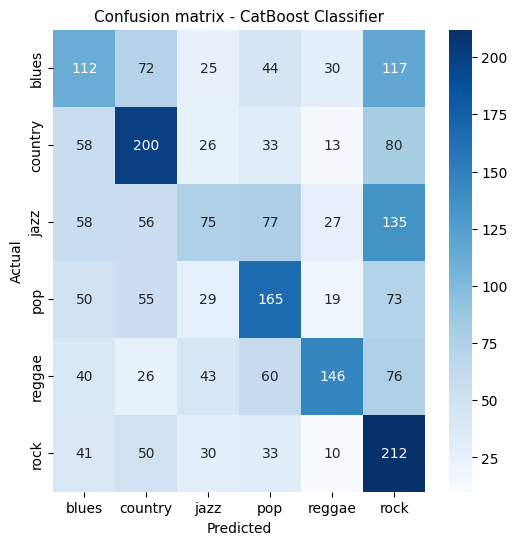

In [97]:
# Confusion matrix - Testing
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm_testing, annot=True, cmap='Blues', fmt='d', xticklabels=df_category_id.genre.values, yticklabels=df_category_id.genre.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion matrix - CatBoost Classifier', size=11);